In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

import seaborn as sns

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()

# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
bias_value = 0
x_train_scaled = x_train.astype('float32')/255 - bias_value
x_test_scaled = x_train.astype('float32')/255 - bias_value

data_variance = np.var(x_train / 255.0)

In [ ]:
np.mean(x_train_scaled)

0.4733649

In [ ]:
idx = np.random.choice(len(x_test_scaled), 10)

# VQ layer

In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x): 
        """
        transformation from inputs to outputs
        Calculate the input shape of the inputs and
        then flatten the inputs keeping `embedding_dim` intact.
        """
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)
        
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)  # only inputs will be remained
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [ ]:
def get_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(32,32,3))
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=1, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(256, 3, activation="relu", strides=1, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
def get_vqvae(latent_dim, num_embeddings):
    
    #defining the layers
    encoder = get_encoder(latent_dim)
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    decoder = get_decoder(latent_dim)

    encoder.summary()
    decoder.summary()

    inputs = keras.Input(shape=(32, 32, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")



In [ ]:
from keras import backend
class VQVAEModel_mseLoss(keras.models.Model):
    def __init__(self, train_variance, latent_dim, num_embeddings, **kwargs):
        super(VQVAEModel_mseLoss, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
 
        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.mse_loss_tracker = keras.metrics.Mean(name="mse_loss")
        # self.negative_log_loss_tracker = keras.metrics.Mean(name="negative_log_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.mse_loss_tracker,
            # self.negative_log_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            reconstructions = self.vqvae(x)

            mse_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            negative_log_loss =  backend.sum(backend.binary_crossentropy(x, reconstructions), axis=-1)
            
            reconstruction_loss = mse_loss

            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        self.mse_loss_tracker.update_state(mse_loss)
        # self.negative_log_loss_tracker.update_state(negative_log_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            # "negative_log_loss": self.negative_log_loss_tracker.result(),
        }

In [ ]:
from keras import backend
class VQVAEModel_logLoss(keras.models.Model):
    def __init__(self, train_variance, latent_dim, num_embeddings, **kwargs):
        super(VQVAEModel_logLoss, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
 
        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.mse_loss_tracker = keras.metrics.Mean(name="mse_loss")
        self.negative_log_loss_tracker = keras.metrics.Mean(name="negative_log_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
            # self.mse_loss_tracker,
            self.negative_log_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            reconstructions = self.vqvae(x)

            mse_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            negative_log_loss =  backend.sum(backend.binary_crossentropy(x, reconstructions), axis=-1)
            
            reconstruction_loss = negative_log_loss

            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # self.mse_loss_tracker.update_state(mse_loss)
        self.negative_log_loss_tracker.update_state(negative_log_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
            # "mse_loss": self.mse_loss_tracker.result(),
            "negative_log_loss": self.negative_log_loss_tracker.result(),
        }

In [ ]:
vqvae_trainer = VQVAEModel_logLoss(data_variance, latent_dim=64, num_embeddings=512)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 64)          16448     
                                                                 
Total params: 404,864
Trainable params: 404,864
Non-trainab

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


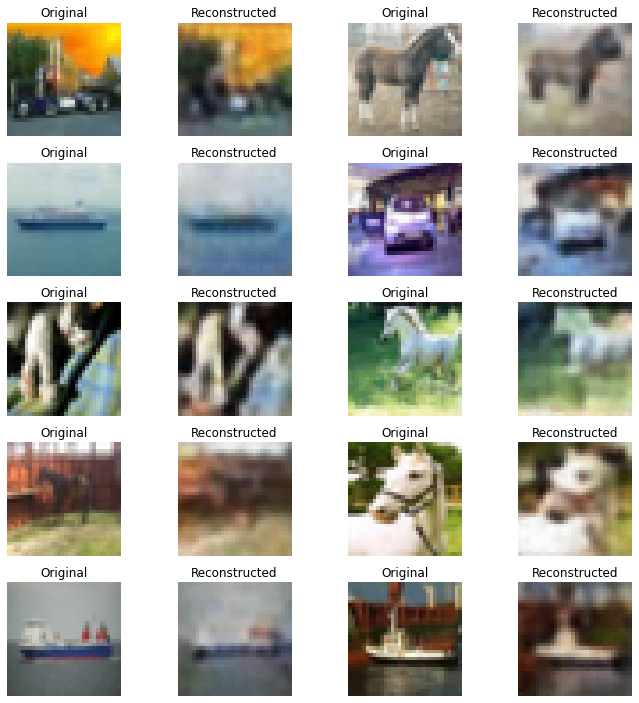

In [ ]:
def visualize(test_images, reconstructions_test):
  fig = plt.figure(figsize=(10, 10))
  counter = 0
  for i in range(test_images.shape[0]):
      plt.subplot(5, 4, counter+1)
      plt.imshow(test_images[i].squeeze() + bias_value)
      # plt.title("Original {} x {}".format(test_images[i].shape[0], test_images[i].shape[1]))
      plt.title("Original")
      plt.axis("off")
      counter = counter +1
      plt.subplot(5, 4, counter+1)
      plt.imshow(reconstructions_test[i].squeeze() + bias_value)
      # plt.title("Reconstructed {} x {}".format(reconstructions_test[i].shape[0], reconstructions_test[i].shape[1]))
      plt.title("Reconstructed")
      plt.axis("off")
      counter = counter +1
      plt.subplots_adjust(wspace=None, hspace=None)

  fig.tight_layout()
  fig.subplots_adjust(top=0.95) 
  plt.show()

  print("\n")


trained_vqvae_model = vqvae_trainer.vqvae

test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

visualize(test_images, reconstructions_test)
# for test_image, reconstructed_image in zip(test_images, reconstructions_test):
#     show_subplot(test_image, reconstructed_image)

(10, 8, 8)


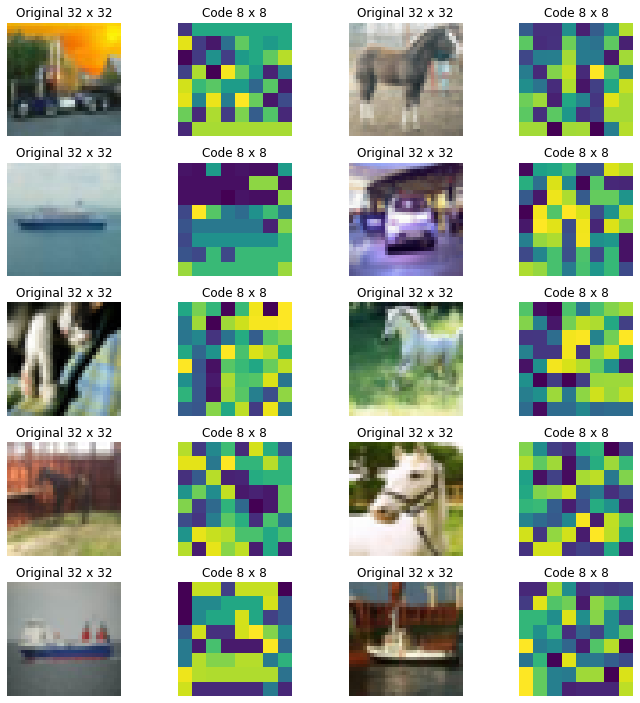

In [ ]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(encoded_outputs.shape[:-1])
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])


def visualize_codes(test_images, codebook_indices):
  fig = plt.figure(figsize=(10, 10))
  counter = 0
  for i in range(test_images.shape[0]):
      plt.subplot(5, 4, counter+1)
      plt.imshow(test_images[i].squeeze() + bias_value)
      plt.title("Original {} x {}".format(test_images[i].shape[0], test_images[i].shape[1]))
      plt.axis("off")
      counter = counter +1
      plt.subplot(5, 4, counter+1)
      plt.imshow(codebook_indices[i].squeeze())
      plt.title("Code {} x {}".format(codebook_indices[i].shape[0], codebook_indices[i].shape[1]))
      plt.axis("off")
      counter = counter +1
      plt.subplots_adjust(wspace=None, hspace=None)

  fig.tight_layout()
  fig.subplots_adjust(top=0.95) 
  plt.show()


visualize_codes(test_images, codebook_indices)

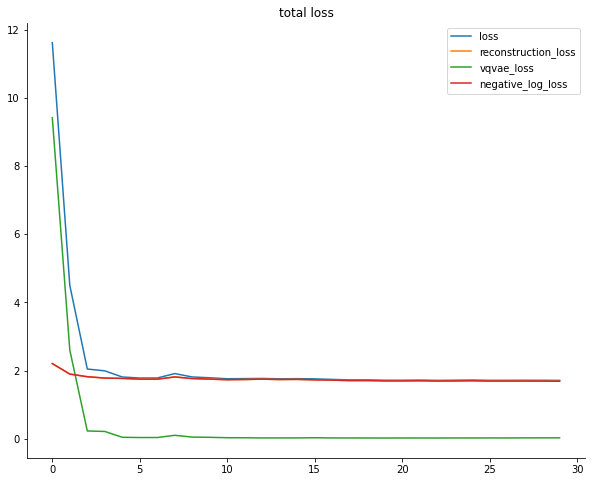

In [ ]:
sns.set_style()
plt.figure(figsize=(10,8))
for key in history.history:

  plt.plot(history.history[key], label=key)
sns.despine()
plt.legend()
plt.title("total loss")
plt.show()